## Importing necessary libraries

In [1]:
import torch
from torchvision import datasets, transforms
from einops import rearrange
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import open3d as o3d
import numpy as np
import pandas as pd
import seaborn as sns
import random
import glob
import cv2
import os

from image import DepthImage

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Read file Helper Method

In [2]:
def read_coordinates(filename):
    # Read pairs of coordinates from the file
    coordinates = np.loadtxt(filename, dtype=np.float32, ndmin=2)
    
    # If needed, reshape the array to have two columns (x, y)
    if coordinates.shape[1] > 2:
        coordinates = coordinates.reshape((-1, 2))
    
    # Convert coordinates to rectangles (x1, y1, x2, y2)
    rectangles = []
    for i in range(0, len(coordinates), 2):
        x1, y1 = int(coordinates[i][0]), int(coordinates[i][1])
        x2, y2 = int(coordinates[i + 1][0]), int(coordinates[i + 1][1])
        
        # Ensure x1, y1 is the top-left corner and x2, y2 is the bottom-right corner
        if x1 > x2:
            x1, x2 = x2, x1
        if y1 > y2:
            y1, y2 = y2, y1
            
        rectangles.append((x1, y1, x2, y2))
        # print((x1, coordinates[i][0], y1, coordinates[i][1], x2, coordinates[i+1][0], y2, coordinates[i+1][1]))
    
    return rectangles

## Task1: Overlay Grasping Rectangles

In [3]:
def overlay_rectangles(image, positive_rectangles, negative_rectangles):
    image_copy = image.copy()

    for rect in positive_rectangles:
        cv2.rectangle(image_copy, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), 2)  # Positive: Green
    for rect in negative_rectangles:
        cv2.rectangle(image_copy, (rect[0], rect[1]), (rect[2], rect[3]), (0, 0, 255), 2)  # Negative: Red
    return image_copy

## Task2: Augment image wit depth channel from pcd files

In [4]:
def generate_depth_image(pcd_file):
    di = DepthImage.from_pcd(pcd_file, (480, 640))
    
    di.inpaint()

    # of_name = pcd.replace('.txt', 'd.tiff')
    # print(of_name)
    return di.img.astype(np.float32)

## Task3: Extract sub-patches and convert to yuv. Seperate color channel and depth channel

In [5]:
def extract_features(rgbd_image, positive_rectangles):
    features = []
    rgbd_image_copy = rgbd_image.copy()
    for rect in positive_rectangles:
        sub_patch = rgbd_image_copy[rect[1]:rect[3], rect[0]:rect[2]]
        # print(rgbd_image.shape)
        # print(sub_patch.shape)
        # print((rect[1]-rect[3], rect[0]-rect[2]))
        yuv_image = cv2.cvtColor(sub_patch[:, :, :3], cv2.COLOR_BGR2YUV)
        color_features = yuv_image[:, :, :3]
        depth_feature = sub_patch[:, :, 3]

        features.append([color_features, depth_feature])

    return features

## Task4: PCA whitening on depth feature

In [6]:
def apply_pca_whitening(depth_feature):
    original_shape = depth_feature.shape
    flattened_depth = depth_feature.flatten().reshape(-1, 1)

    pca = PCA(whiten=True)
    whitened_depth = pca.fit_transform(flattened_depth)

    # Reshape whitened_depth to the original shape
    whitened_depth = whitened_depth.reshape(original_shape)

    return whitened_depth

## Task 5: Visualize Point Cloud Data

In [7]:
def visualize_point_cloud(point_cloud_data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point_cloud_data[:, 0], point_cloud_data[:, 1], point_cloud_data[:, 2])
    plt.show()

## Parse dataset

Current Directory: /media/volume/sdb/data_592/robitics_grasp/10


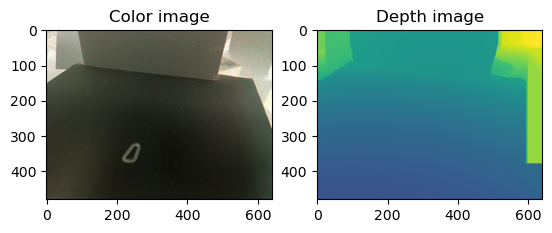

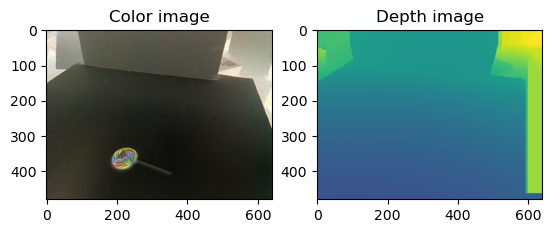

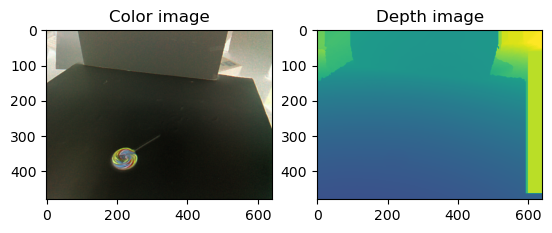

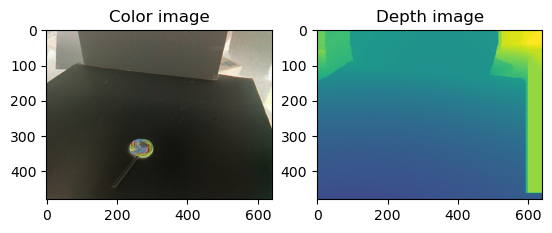

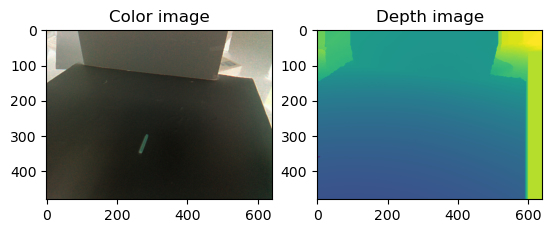

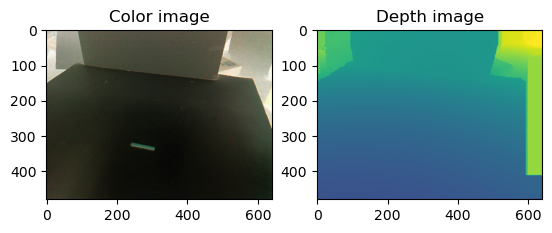

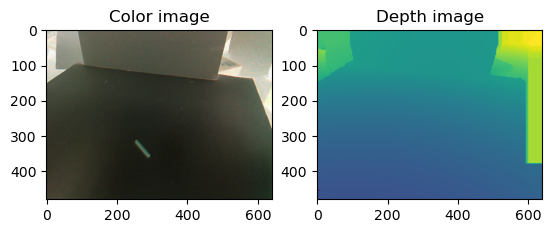

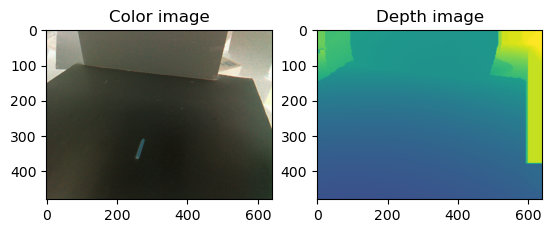

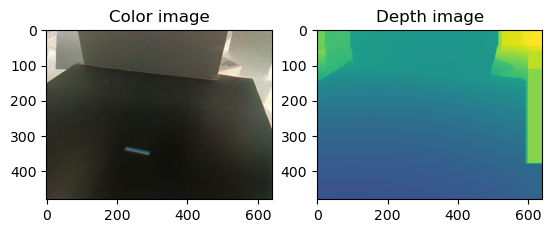

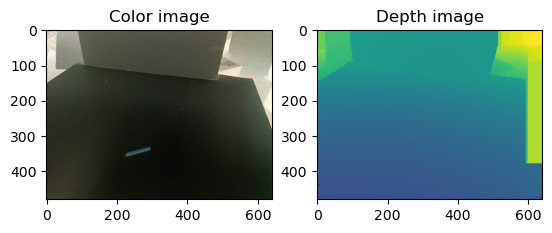

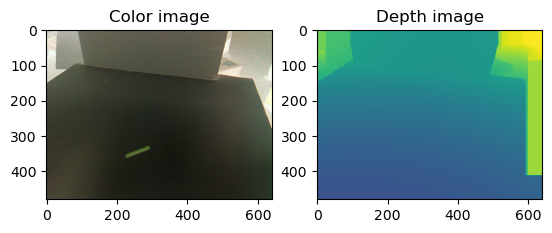

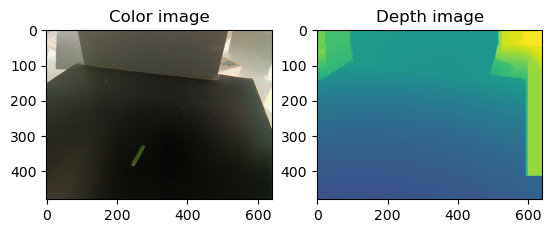

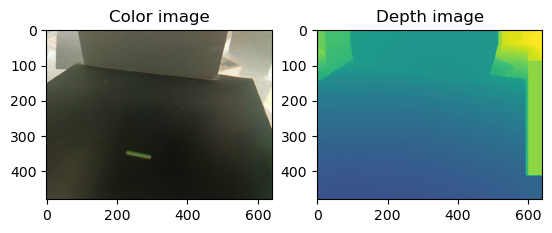

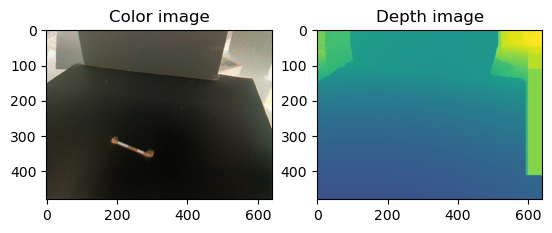

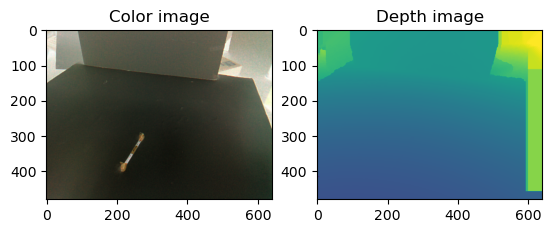

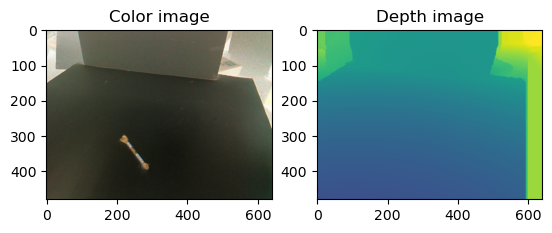

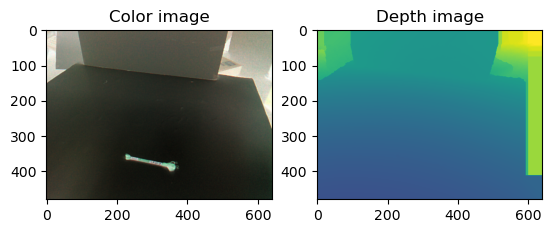

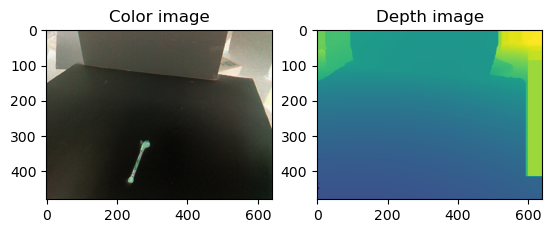

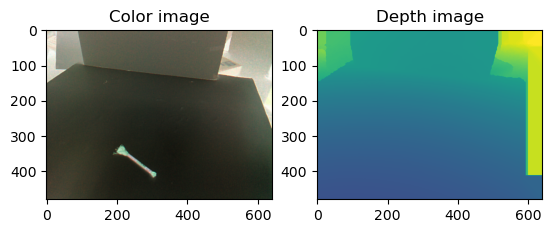

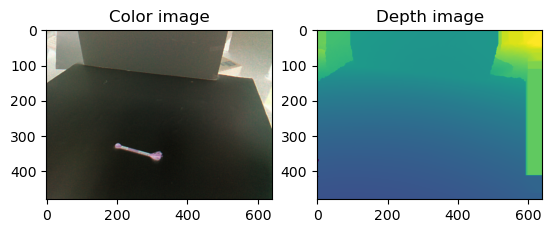

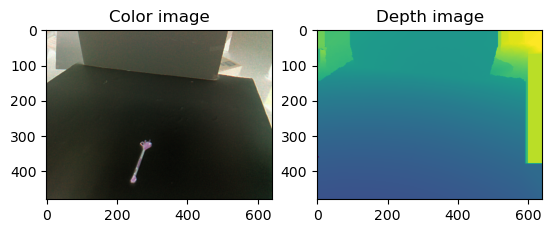

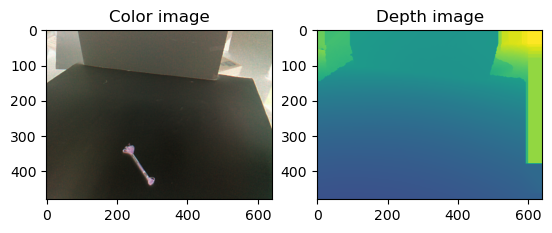

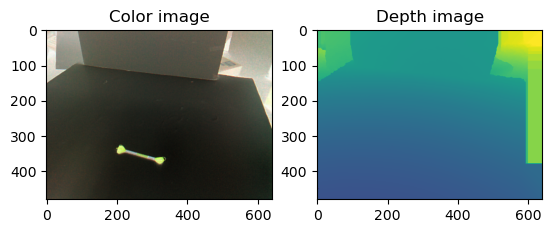

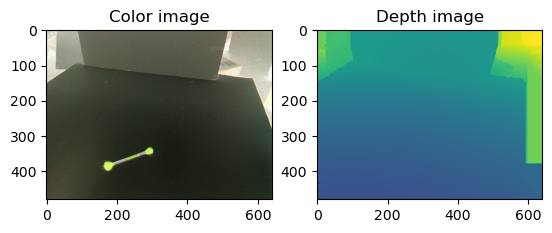

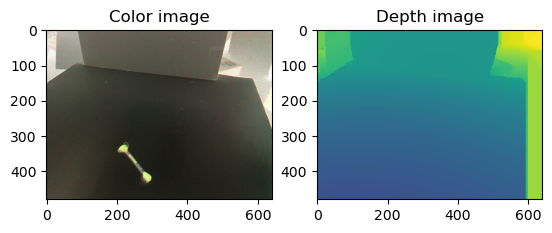

error: OpenCV(4.5.2) ../modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [8]:
data_folder = os.path.join(os.path.dirname(os.getcwd()), "data_592", "robitics_grasp", "10")
print("Current Directory:", data_folder)

cneg_pattern = "*cneg.txt"
cpos_pattern = "*cpos.txt"
pcd_pattern = "pcd[0-9][0-9][0-9][0-9].txt"
png_pattern = "*.png"
tiff_pattern = "*.tiff"

cneg_files = sorted(glob.glob(os.path.join(data_folder, cneg_pattern)))
cpos_files = sorted(glob.glob(os.path.join(data_folder, cpos_pattern)))
pcd_files = sorted(glob.glob(os.path.join(data_folder, pcd_pattern)))
png_files = sorted(glob.glob(os.path.join(data_folder, png_pattern)))
tiff_files = sorted(glob.glob(os.path.join(data_folder, tiff_pattern)))

# Iterate over matching files and process them
for cneg_file, cpos_file, pcd_file, png_file, tiff_file in zip(cneg_files, cpos_files, pcd_files, png_files, tiff_files):
    # print(cneg_file)
    # print(cpos_file)
    # print(png_file)
    positive_rectangles = read_coordinates(cpos_file)
    negative_rectangles = read_coordinates(cneg_file)
    png_image = cv2.imread(png_file)
    # tiff_image = imageio.imread(tiff_file)
    overlayed_png_image = overlay_rectangles(png_image, positive_rectangles, negative_rectangles)
    
    # cv2.imshow("Overlay on PNG", png_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    depth_image = generate_depth_image(pcd_file).reshape(480,640,1)
    rgbd_image = np.concatenate([png_image, depth_image], axis=2)
    
    features = extract_features(rgbd_image, positive_rectangles)
    for feature in features:
        feature[1] = apply_pca_whitening(feature[1])
    
    plt.subplot(1, 2, 1)
    plt.title('Color image')
    plt.imshow((rgbd_image[:,:,:3]* 255).astype(np.uint8))
    plt.subplot(1, 2, 2)
    plt.title('Depth image')
    plt.imshow(rgbd_image[:,:,3:])
    plt.show()
    
#     break